# Plant Seedlings Image Classification Using CNN by Abimbola Salami

In [1]:
#Importing required libraries

import os
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from glob import glob
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.utils import np_utils
from keras import utils as np_utils
from tensorflow.keras import utils as np_utils
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras import losses, optimizers
from keras.applications.mobilenet import MobileNet, preprocess_input

from tqdm.notebook import tqdm_notebook as tqdm
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the datasets

import numpy as np
import pandas as pd
images = np.load('/content/drive/My Drive/Plant_Seedling/images.npy')   
labels = pd.read_csv('/content/drive/My Drive/Plant_Seedling/Labels.csv') 

In [4]:
# Checking the shapes of the datasets

print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


In [5]:
print(labels.value_counts())

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64


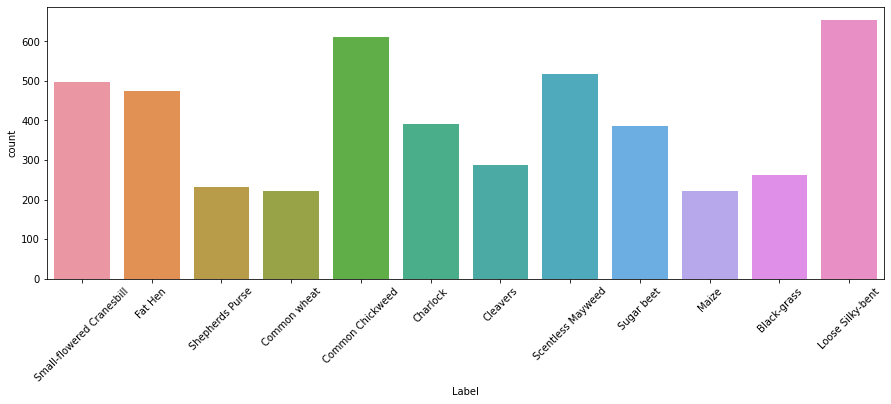

In [6]:
# Displaying labels in the dataset
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.countplot(x="Label", data=labels)

In [7]:
CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

INV_CLASS = {CLASS[j]:j for j in CLASS}

In [8]:
labels_list = []
for label in labels.Label:
    labels_list.append(CLASS[label])

In [9]:
labels_list = np.array(labels_list)
labels_list.shape

(4750,)

In [10]:
# Converting labets to one-hot-vectors

labels_cat = keras.utils.np_utils.to_categorical(labels_list,len(CLASS))
print(labels_cat.shape)

(4750, 12)


In [11]:
labels_cat

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

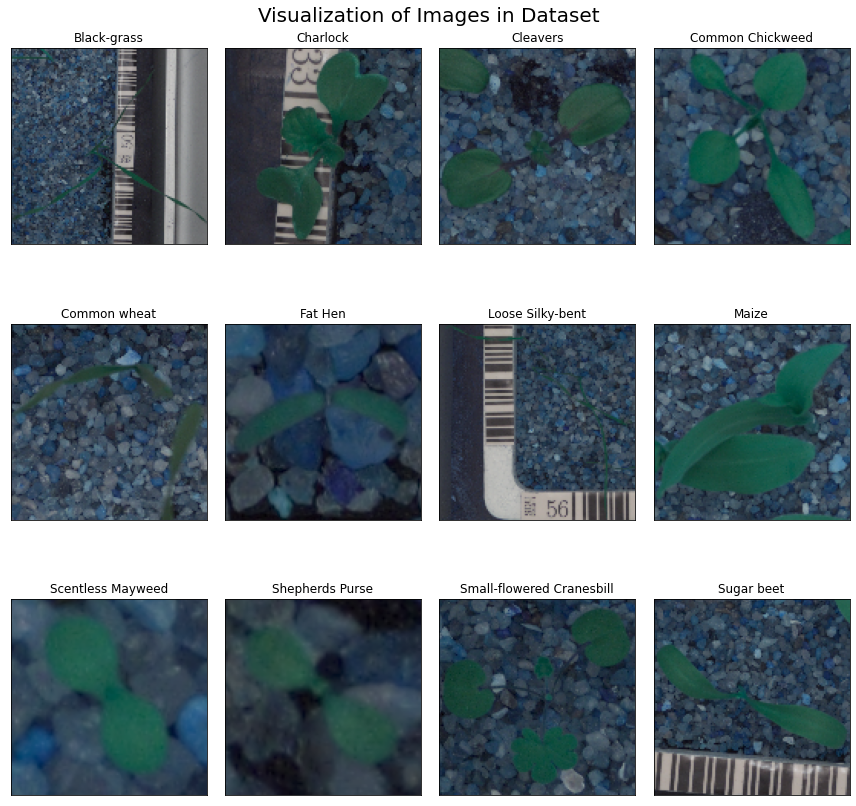

In [12]:
# Visualizing the images in dataset

plt.figure(figsize=(12,12))

for i in range(12):  
    
  plt.subplot(3,4,i+1)
    
  index = np.where(labels_list==i)[0][1]
  plt.imshow(images[index])
  plt.title(INV_CLASS[np.argmax(labels_cat[index])])
  plt.xticks([]), plt.yticks([])

plt.suptitle("Visualization of Images in Dataset", fontsize=20)    
plt.tight_layout()
plt.show()

### Data Pre-processing

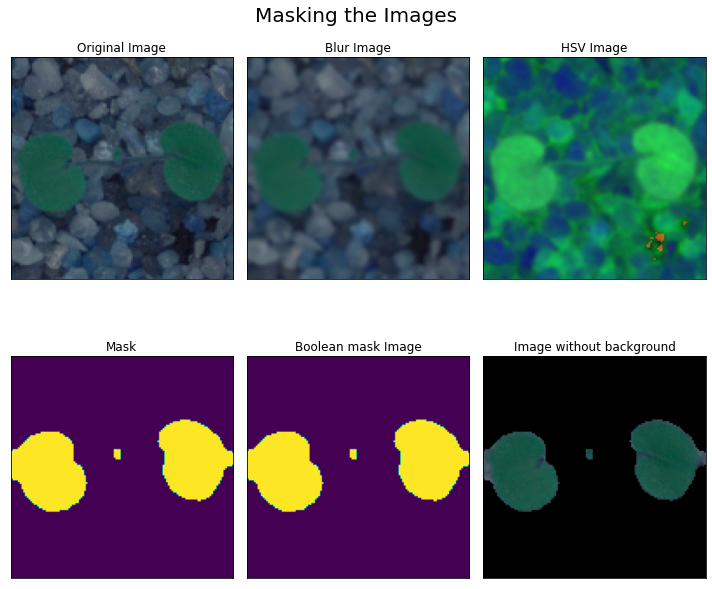

In [13]:
clearImg = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in images:
    
    # Using Gaussian Blurring
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Converting to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Creating mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Creating Boolean mask
    bMask = mask > 0  
    
    # Applying the mask
    clear = np.zeros_like(img, np.uint8)  # Creating empty image
    clear[bMask] = img[bMask]  # Applying boolean mask to the origin image
    
    clearImg.append(clear)  # Appending image without backgroung
    
    # Showing examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.xticks([]), plt.yticks([]), plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.xticks([]), plt.yticks([]), plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.xticks([]), plt.yticks([]), plt.title("Boolean mask Image")
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False

plt.suptitle("Masking the Images", fontsize=20)
plt.tight_layout()

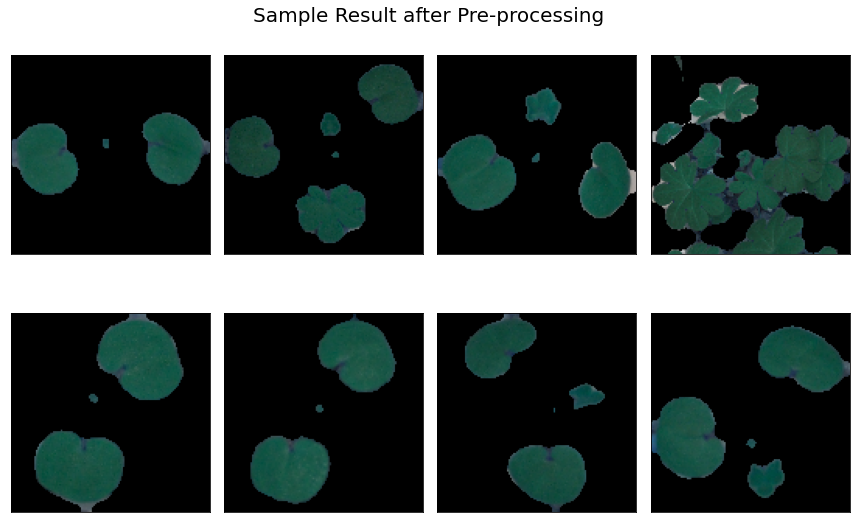

In [14]:
# Visulaising the data after pre-processing
clearImg = np.asarray(clearImg)
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearImg[i])
    plt.xticks([]), plt.yticks([])
    
plt.suptitle("Sample Result after Pre-processing", fontsize=20)  
plt.tight_layout()
plt.show()

In [15]:
clearImg = clearImg / 255

In [16]:
# Splitting the datasets

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size=0.30, random_state=42)

#Split Test Data into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [17]:
# Checking the shape of the datasets after splitting

print('X_train shape is:', X_train.shape)
print('y_train shape is:', y_train.shape)
print('X_test shape is:', X_test.shape)
print('y_test shape is:', y_test.shape)
print('X_val shape is:', X_val.shape)
print('y_val shape is:', y_val.shape)

X_train shape is: (3325, 128, 128, 3)
y_train shape is: (3325, 12)
X_test shape is: (713, 128, 128, 3)
y_test shape is: (713, 12)
X_val shape is: (712, 128, 128, 3)
y_val shape is: (712, 12)


- The dataset is already in a compatible shape

In [18]:
y_test2 = y_test.copy()

### Building the CNN

In [19]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

In [20]:
# Defining the layers

tf.keras.backend.clear_session() #clear the weights

np.random.seed(2)  # Fix seed

model = Sequential([Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                    
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                   
                    Conv2D(filters=256, kernel_size=(5, 5), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                   
                    Flatten(),
                    
                    Dense(256, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                   
                    Dense(256, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                   
                    Dense(12, activation='softmax')])

model.summary()

# Setting the optimizer and loss functions

# initiate Adam optimizer
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
# compile model
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       2

In [21]:
#Adding Early stopping callback to the fit function is going to stop the training
#if the val_accuracy is not going to change even '0.001' for more than 50 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

Epoch 1/500
104/104 [==============================] - 65s 282ms/step - loss: 2.3304 - accuracy: 0.3573 - val_loss: 19.7711 - val_accuracy: 0.1629

Epoch 00001: val_loss improved from inf to 19.77114, saving model to checkpoint_01_loss19.7711.h5
Epoch 2/500
104/104 [==============================] - 23s 225ms/step - loss: 1.4552 - accuracy: 0.5528 - val_loss: 1.9249 - val_accuracy: 0.4340

Epoch 00002: val_loss improved from 19.77114 to 1.92485, saving model to checkpoint_02_loss1.9249.h5
Epoch 3/500
104/104 [==============================] - 23s 225ms/step - loss: 1.1534 - accuracy: 0.6247 - val_loss: 4.0860 - val_accuracy: 0.2865

Epoch 00003: val_loss did not improve from 1.92485
Epoch 4/500
104/104 [==============================] - 23s 225ms/step - loss: 0.9220 - accuracy: 0.7071 - val_loss: 1.8533 - val_accuracy: 0.4888

Epoch 00004: val_loss improved from 1.92485 to 1.85327, saving model to checkpoint_04_loss1.8533.h5
Epoch 5/500
104/104 [==============================] - 23s 22

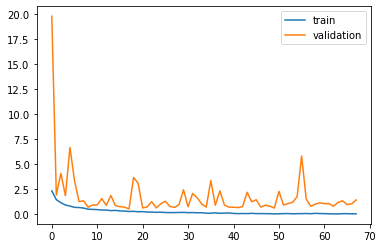

In [22]:
# Fitting the model

history = model.fit(X_train,
                    y_train,
                    batch_size=None,
                    epochs=500,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

<Figure size 1440x720 with 0 Axes>

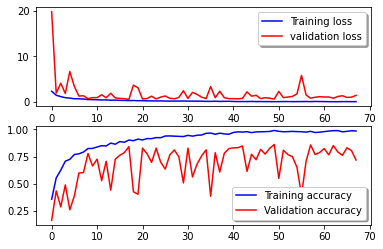

In [23]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
# Evaluating the trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', np.round(scores[0], 4))
print('Test accuracy:', np.round(scores[1], 4))

23/23 [==============================] - 3s 115ms/step - loss: 1.4344 - accuracy: 0.7265
Test loss: 1.4344
Test accuracy: 0.7265


In [25]:
y_pred = model.predict(X_test)

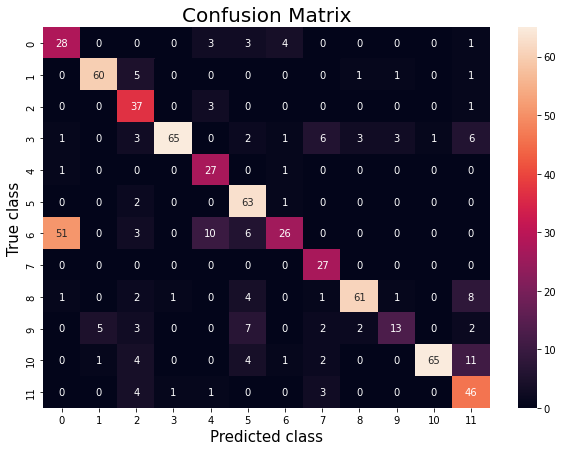

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted class', fontsize=15)
plt.ylabel('True class', fontsize=15);

In [27]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.34      0.72      0.46        39
           1       0.91      0.88      0.90        68
           2       0.59      0.90      0.71        41
           3       0.97      0.71      0.82        91
           4       0.61      0.93      0.74        29
           5       0.71      0.95      0.81        66
           6       0.76      0.27      0.40        96
           7       0.66      1.00      0.79        27
           8       0.91      0.77      0.84        79
           9       0.72      0.38      0.50        34
          10       0.98      0.74      0.84        88
          11       0.61      0.84      0.70        55

    accuracy                           0.73       713
   macro avg       0.73      0.76      0.71       713
weighted avg       0.78      0.73      0.72       713



- The model acheived accuracy of 73%

In [28]:
y_pred_Classes = np.argmax(y_pred, axis = 1) 
y_test = np.argmax(y_test, axis = 1)

Model Prediction for Sample 2


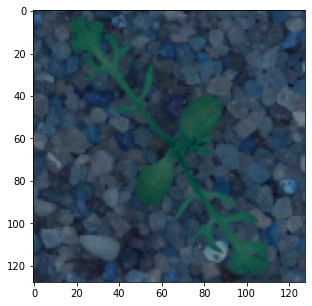

True Class: Scentless Mayweed
Predicted Class: Scentless Mayweed
--------------------------------------------------
Model Prediction for Sample 3


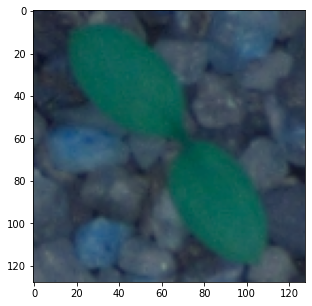

True Class: Common Chickweed
Predicted Class: Common Chickweed
--------------------------------------------------
Model Prediction for Sample 33


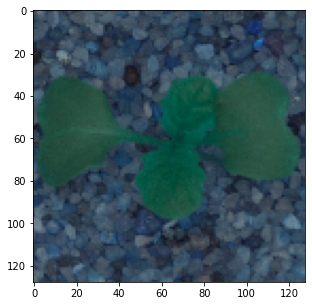

True Class: Charlock
Predicted Class: Charlock
--------------------------------------------------
Model Prediction for Sample 36


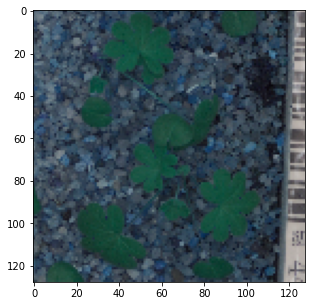

True Class: Small-flowered Cranesbill
Predicted Class: Cleavers
--------------------------------------------------
Model Prediction for Sample 59


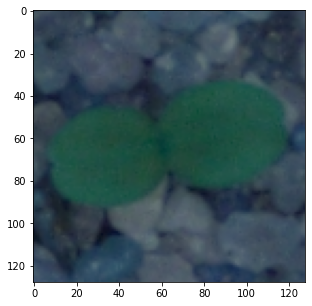

True Class: Cleavers
Predicted Class: Cleavers
--------------------------------------------------


In [29]:
## Visualise specific images in the test set
for i in [2,3,33,36,59]:
  print("Model Prediction for Sample", i)
  X_test[i]
  plt.figure(figsize=(10,5))
  plt.imshow(X_test[i], cmap='Accent')
  plt.show()
  print("True Class:", INV_CLASS.get(y_test[i]))
  print("Predicted Class:", INV_CLASS.get(y_pred_Classes[i]))
  print(50 * "-")

- The model predicted all the images correctly except from "Small-flowered Cranesbill" which is wrongly predicted as "Cleavers"

#### Building the Second Model 2

In [30]:
model2 = Sequential()

model2.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.1))

model2.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.1))

model2.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.1))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(12, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization_8 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)      

In [31]:
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

In [32]:

#Adding Early stopping callback to the fit function is going to stop the training
#if the val_accuracy is not going to change even '0.001' for more than 50 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model2_checkpoint =  ModelCheckpoint('checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

Epoch 1/500
104/104 [==============================] - 28s 245ms/step - loss: 2.3405 - accuracy: 0.3365 - val_loss: 17.9628 - val_accuracy: 0.2542

Epoch 00001: val_loss improved from inf to 17.96284, saving model to checkpoint_01_loss17.9628.h5
Epoch 2/500
104/104 [==============================] - 24s 233ms/step - loss: 1.4407 - accuracy: 0.5489 - val_loss: 3.4477 - val_accuracy: 0.4228

Epoch 00002: val_loss improved from 17.96284 to 3.44774, saving model to checkpoint_02_loss3.4477.h5
Epoch 3/500
104/104 [==============================] - 24s 233ms/step - loss: 1.0873 - accuracy: 0.6433 - val_loss: 1.9948 - val_accuracy: 0.4438

Epoch 00003: val_loss improved from 3.44774 to 1.99476, saving model to checkpoint_03_loss1.9948.h5
Epoch 4/500
104/104 [==============================] - 24s 233ms/step - loss: 0.9623 - accuracy: 0.6830 - val_loss: 2.9911 - val_accuracy: 0.4270

Epoch 00004: val_loss did not improve from 1.99476
Epoch 5/500
104/104 [==============================] - 24s 23

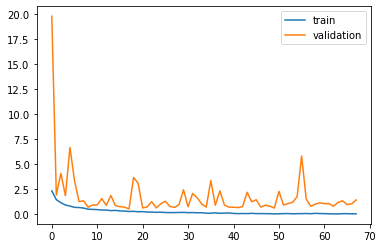

In [33]:
history2 = model2.fit(X_train,
                    y_train,
                    batch_size=None,
                    epochs=500,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping, lrr, model2_checkpoint])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [34]:
# Score trained model.
scores2 = model2.evaluate(X_test, y_test2, verbose=1)
print('Test loss:', np.round(scores[0], 4))
print('Test accuracy:', np.round(scores[1], 4))

23/23 [==============================] - 2s 78ms/step - loss: 0.6776 - accuracy: 0.8668
Test loss: 1.4344
Test accuracy: 0.7265


In [35]:
y_pred2 = model2.predict(X_test)

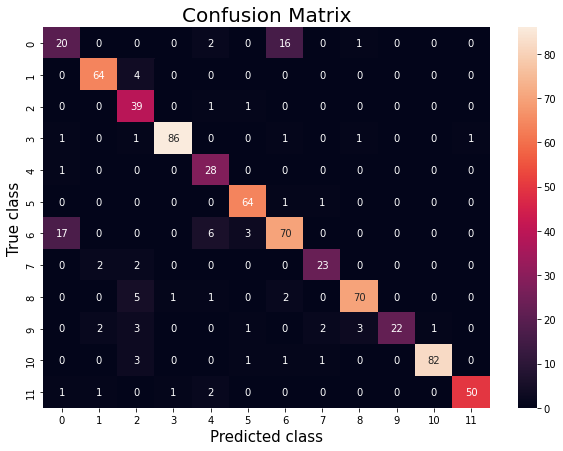

In [36]:
# Confusion matrix
cm = confusion_matrix(y_test2.argmax(axis=1), y_pred2.argmax(axis=1))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted class', fontsize=15)
plt.ylabel('True class', fontsize=15);

In [37]:
print(classification_report(y_test2.argmax(axis=1), y_pred2.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.50      0.51      0.51        39
           1       0.93      0.94      0.93        68
           2       0.68      0.95      0.80        41
           3       0.98      0.95      0.96        91
           4       0.70      0.97      0.81        29
           5       0.91      0.97      0.94        66
           6       0.77      0.73      0.75        96
           7       0.85      0.85      0.85        27
           8       0.93      0.89      0.91        79
           9       1.00      0.65      0.79        34
          10       0.99      0.93      0.96        88
          11       0.98      0.91      0.94        55

    accuracy                           0.87       713
   macro avg       0.85      0.85      0.85       713
weighted avg       0.88      0.87      0.87       713



- The second model has an accuracy of 87% which is an improvement from the previous model

In [38]:
y_pred2_Classes = np.argmax(y_pred2, axis = 1) 
y_test2 = np.argmax(y_test2, axis = 1)

Model Prediction for Sample 2


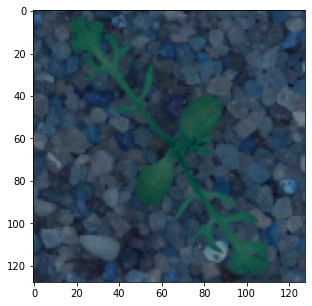

True Class: Scentless Mayweed
Predicted Class: Scentless Mayweed
--------------------------------------------------
Model Prediction for Sample 3


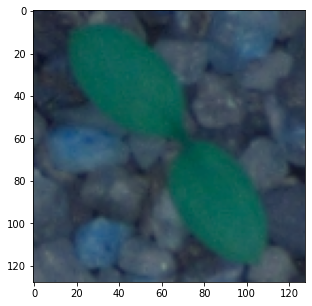

True Class: Common Chickweed
Predicted Class: Common Chickweed
--------------------------------------------------
Model Prediction for Sample 33


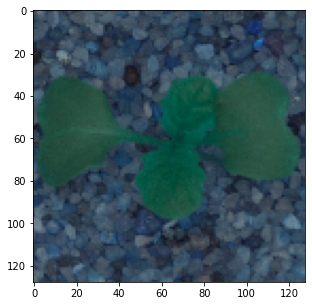

True Class: Charlock
Predicted Class: Charlock
--------------------------------------------------
Model Prediction for Sample 36


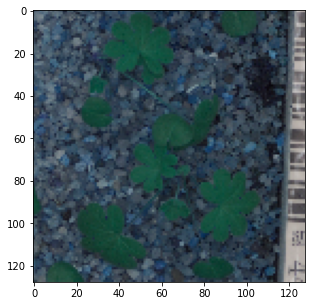

True Class: Small-flowered Cranesbill
Predicted Class: Cleavers
--------------------------------------------------
Model Prediction for Sample 59


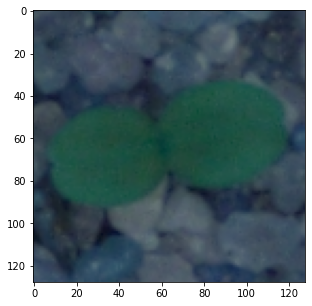

True Class: Cleavers
Predicted Class: Cleavers
--------------------------------------------------


In [39]:
## Visualise specific images in the test set
for i in [2,3,33,36,59]:
  print("Model Prediction for Sample", i)
  X_test[i]
  plt.figure(figsize=(10,5))
  plt.imshow(X_test[i], cmap='Accent')
  plt.show()
  print("True Class:", INV_CLASS.get(y_test2[i]))
  print("Predicted Class:", INV_CLASS.get(y_pred2_Classes[i]))
  print(50 * "-")

### Conclusion

- From the two models, Model 2 has a higher accuracy score than model one and will be a preferred model for prediction
- Both models are unable to correctly predict the "Small-flowered Cranesbill"